In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from IPython.display import display # Allows the use of display() for DataFrames
%matplotlib inline

In [2]:
df=pd.read_csv("../demographics.csv")
df.head(5)

,Gender,Age,MaritalStatus,NuChildren,ResidencyDist,Ubudehe,StudentStatus,EducationLvl,LastSchoolCat,HTLast3yrs,EmployedLast1yr,OccupancyStatus
0,Male,31,Married,1-2,Nyarugenge,2.0,No,Senior 6,Public school,No,No,Owner occupier
1,Male,33,Single,None,Nyarugenge,2.0,No,Bachelor degree,Private school,Yes,No,Owner occupier
2,Male,26,Single,None,Nyamasheke,3.0,No,Senior 6,Private school,No,Yes,Tenancy – Renting
3,Male,23,Single,None,Nyarugenge,2.0,No,Senior 6,Private school,Yes,Yes,Tenancy – Renting
4,Female,24,Single,None,Gasabo,3.0,No,Senior 6,Private school,Yes,No,Dwelling (house) provided free of charge


# Data Exploration

12 columns, mostly categorical data - Only numeric data is Ubudehe



In [3]:
df.describe()

,Ubudehe
count,888.000000
mean,2.498874
std,0.666478
min,1.000000
25%,2.000000
50%,3.000000
75%,3.000000
max,6.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 925 entries, 0 to 924
Data columns (total 12 columns):
Gender             925 non-null object
Age                925 non-null object
MaritalStatus      925 non-null object
NuChildren         925 non-null object
ResidencyDist      888 non-null object
Ubudehe            888 non-null float64
StudentStatus      888 non-null object
EducationLvl       844 non-null object
LastSchoolCat      860 non-null object
HTLast3yrs         860 non-null object
EmployedLast1yr    860 non-null object
OccupancyStatus    786 non-null object
dtypes: float64(1), object(11)
memory usage: 86.8+ KB


In [5]:
#Due to improper data entry, some ages were 0.. The mean of the correctly entered ones is 34. 
df.Age.replace({"0":30, "#NUM!":32,"05/18/1994":26}, inplace=True)

In [6]:
df.mode()

,Gender,Age,MaritalStatus,NuChildren,ResidencyDist,Ubudehe,StudentStatus,EducationLvl,LastSchoolCat,HTLast3yrs,EmployedLast1yr,OccupancyStatus
0,Male,30,Single,None,Gasabo,3.0,No,Senior 6,Private school,No,Yes,Tenancy – Renting


1. The most rep gender is Male
2. Most frequent age is 30 -for obvious reasons
3. Number of children - None
4. Gasabo
5. Ubudehe 3
6. Last school cat= Private
7. Educations- senior 6
8. Employed - Yes
9. Occupancy -Tenant Renting
10. HT = No
11. single

In [7]:
df=df.fillna(df.mode())

In [8]:
null=df.isnull().any()
null_index=list(null.index)
null_index
list(null)

[False, False, False, False, True, True, True, True, True, True, True, True]

In [11]:
df.isnull().sum()

Gender             0
Age                0
MaritalStatus      0
NuChildren         0
ResidencyDist      0
Ubudehe            0
StudentStatus      0
EducationLvl       0
LastSchoolCat      0
HTLast3yrs         0
EmployedLast1yr    0
OccupancyStatus    0
dtype: int64

In [10]:
# Filling in null with the mode
for i in range(len(null_index)):
    if null[i]==True:
        df[null_index[i]]= df[null_index[i]].fillna(df[null_index[i]].mode()[0])

In [12]:
df.Age=pd.to_numeric(df.Age)

In [13]:
df.Age.replace({1:30, 2:24, 3:28, 4:26,7973:22, 75:27}, inplace=True)
df.Ubudehe.replace({5:4, 6:4}, inplace=True)

In [14]:
df.describe()

,Age,Ubudehe
count,925.000000,925.000000
mean,26.341622,2.515676
std,4.264528,0.648861
min,18.000000,1.000000
25%,23.000000,2.000000
50%,26.000000,3.000000
75%,30.000000,3.000000
max,49.000000,4.000000


In [15]:
from collections import defaultdict

encoder=defaultdict(LabelEncoder)
encoder

defaultdict(sklearn.preprocessing.label.LabelEncoder, {})

In [16]:
fit=df.loc[:, ['Gender',  'MaritalStatus', 'NuChildren', 'ResidencyDist',
       'StudentStatus', 'EducationLvl', 'LastSchoolCat',
       'HTLast3yrs', 'EmployedLast1yr', 'OccupancyStatus']].apply(lambda x:encoder[x.name].fit_transform(x))
fit.head()

,Gender,MaritalStatus,NuChildren,ResidencyDist,StudentStatus,EducationLvl,LastSchoolCat,HTLast3yrs,EmployedLast1yr,OccupancyStatus
0,1,0,0,20,0,13,2,0,0,3
1,1,1,4,20,0,5,0,1,0,3
2,1,1,4,18,0,13,0,0,1,5
3,1,1,4,20,0,13,0,1,1,5
4,0,1,4,2,0,13,0,1,0,2


In [17]:
new_df=fit.copy()+1  # will do log transformation which doesn't work with zeros
new_df["Age"]=df.Age
new_df["Ubudehe"]=df.Ubudehe
new_df.head()

,Gender,MaritalStatus,NuChildren,ResidencyDist,StudentStatus,EducationLvl,LastSchoolCat,HTLast3yrs,EmployedLast1yr,OccupancyStatus,Age,Ubudehe
0,2,1,1,21,1,14,3,1,1,4,31,2.0
1,2,2,5,21,1,6,1,2,1,4,33,2.0
2,2,2,5,19,1,14,1,1,2,6,26,3.0
3,2,2,5,21,1,14,1,2,2,6,23,2.0
4,1,2,5,3,1,14,1,2,1,3,24,3.0


In [18]:
df.columns

Index(['Gender', 'Age', 'MaritalStatus', 'NuChildren', 'ResidencyDist',
       'Ubudehe', 'StudentStatus', 'EducationLvl', 'LastSchoolCat',
       'HTLast3yrs', 'EmployedLast1yr', 'OccupancyStatus'],
      dtype='object')

In [19]:
new_df.describe()

,Gender,MaritalStatus,NuChildren,ResidencyDist,StudentStatus,EducationLvl,LastSchoolCat,HTLast3yrs,EmployedLast1yr,OccupancyStatus,Age,Ubudehe
count,925.000000,925.000000,925.000000,925.000000,925.000000,925.000000,925.000000,925.000000,925.000000,925.000000,925.000000,925.000000
mean,1.525405,1.943784,4.698378,11.020541,1.309189,9.949189,1.902703,1.422703,1.603243,4.732973,26.341622,2.515676
std,0.499624,0.239671,1.036586,7.516836,0.462409,4.755108,0.954168,0.494256,0.489489,1.339156,4.264528,0.648861
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,18.000000,1.000000
25%,1.000000,2.000000,5.000000,3.000000,1.000000,6.000000,1.000000,1.000000,1.000000,4.000000,23.000000,2.000000
50%,2.000000,2.000000,5.000000,11.000000,1.000000,14.000000,1.000000,1.000000,2.000000,5.000000,26.000000,3.000000
75%,2.000000,2.000000,5.000000,21.000000,2.000000,14.000000,3.000000,2.000000,2.000000,6.000000,30.000000,3.000000
max,2.000000,3.000000,5.000000,28.000000,2.000000,14.000000,3.000000,2.000000,2.000000,6.000000,49.000000,4.000000


In [20]:
data=new_df

In [21]:
data.corr()

,Gender,MaritalStatus,NuChildren,ResidencyDist,StudentStatus,EducationLvl,LastSchoolCat,HTLast3yrs,EmployedLast1yr,OccupancyStatus,Age,Ubudehe
Gender,1.000000,-0.060364,-0.028027,0.050723,-0.052775,-0.022461,0.091457,0.085752,0.140829,0.166242,0.265131,-0.105553
MaritalStatus,-0.060364,1.000000,0.694009,0.006048,0.078882,0.028829,0.028113,-0.128083,-0.061175,-0.073796,-0.325321,-0.001287
NuChildren,-0.028027,0.694009,1.000000,-0.008093,0.057042,0.054852,0.041420,-0.137444,-0.050540,-0.094726,-0.320641,0.068986
ResidencyDist,0.050723,0.006048,-0.008093,1.000000,0.044253,-0.027282,0.050526,0.059416,-0.023078,-0.046008,-0.003967,0.004483
StudentStatus,-0.052775,0.078882,0.057042,0.044253,1.000000,-0.021395,0.060898,-0.075258,-0.122058,0.035600,-0.179851,-0.026992
EducationLvl,-0.022461,0.028829,0.054852,-0.027282,-0.021395,1.000000,-0.105328,-0.060385,0.054100,-0.019638,-0.222816,0.046735
LastSchoolCat,0.091457,0.028113,0.041420,0.050526,0.060898,-0.105328,1.000000,-0.029734,-0.045667,-0.017814,-0.063900,-0.118149
HTLast3yrs,0.085752,-0.128083,-0.137444,0.059416,-0.075258,-0.060385,-0.029734,1.000000,0.300304,0.061165,0.138852,-0.022371
EmployedLast1yr,0.140829,-0.061175,-0.050540,-0.023078,-0.122058,0.054100,-0.045667,0.300304,1.000000,0.171708,0.129809,0.055382
OccupancyStatus,0.166242,-0.073796,-0.094726,-0.046008,0.035600,-0.019638,-0.017814,0.061165,0.171708,1.000000,0.194507,-0.094195


In [22]:
samples=data.iloc[[10, 400, 293],:]

In [23]:
samples_raw=df.iloc[[10, 400, 293],:]
samples_raw
samples_raw.to_csv("samples.csv")

In [24]:
samples

,Gender,MaritalStatus,NuChildren,ResidencyDist,StudentStatus,EducationLvl,LastSchoolCat,HTLast3yrs,EmployedLast1yr,OccupancyStatus,Age,Ubudehe
10,2,1,1,13,2,14,3,1,1,4,31,2.0
400,1,2,5,3,1,14,2,2,2,6,30,3.0
293,1,2,5,21,1,6,1,2,2,5,28,3.0


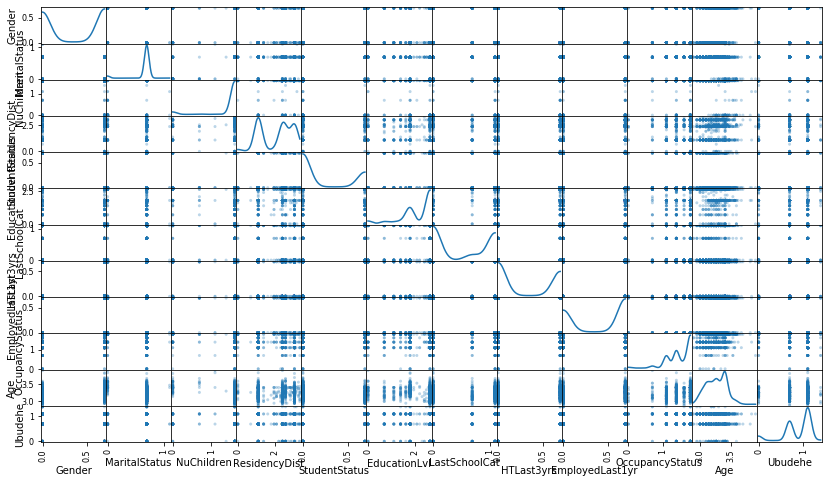

In [25]:
# TODO: Scale the data using the natural logarithm
log_data = np.log(data)

# TODO: Scale the sample data using the natural logarithm
log_samples = np.log(samples)

# Produce a scatter matrix for each pair of newly-transformed features
pd.plotting.scatter_matrix(log_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

In [26]:
# Select the indices for data points you wish to remove
import itertools
outliers_lst  = []

# For each feature find the data points with extreme high or low values
for feature in log_data.columns:
    # TODO: Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(log_data.loc[:, feature], 25)

    # TODO: Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(log_data.loc[:, feature], 75)

    # TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = 1.5 * (Q3 - Q1)

    # Display the outliers
    print("Data points considered outliers for the feature '{}':".format(feature))

    # The tilde sign ~ means not
    # So here, we're finding any points outside of Q1 - step and Q3 + step
    outliers_rows = log_data.loc[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step)), :]
    # display(outliers_rows)

    outliers_lst.append(list(outliers_rows.index))

outliers = list(itertools.chain.from_iterable(outliers_lst))

# List of unique outliers
# We use set()
# Sets are lists with no duplicate entries
uniq_outliers = list(set(outliers))

# List of duplicate outliers
dup_outliers = list(set([x for x in outliers if outliers.count(x) > 1]))

print('Outliers list:\n', uniq_outliers)
print('Length of outliers list:\n', len(uniq_outliers))

print('Duplicate list:\n', dup_outliers)
print('Length of duplicates list:\n', len(dup_outliers))

# Remove duplicate outliers
# Only 5 specified
good_data = log_data.drop(log_data.index[dup_outliers]).reset_index(drop = True)

# Original Data 
print('Original shape of data:\n', data.shape)
# Processed Data
print('New shape of data:\n', good_data.shape)


Data points considered outliers for the feature 'Gender':
Data points considered outliers for the feature 'MaritalStatus':
Data points considered outliers for the feature 'NuChildren':
Data points considered outliers for the feature 'ResidencyDist':
Data points considered outliers for the feature 'StudentStatus':
Data points considered outliers for the feature 'EducationLvl':
Data points considered outliers for the feature 'LastSchoolCat':
Data points considered outliers for the feature 'HTLast3yrs':
Data points considered outliers for the feature 'EmployedLast1yr':
Data points considered outliers for the feature 'OccupancyStatus':
Data points considered outliers for the feature 'Age':
Data points considered outliers for the feature 'Ubudehe':
Outliers list:
 [0, 512, 516, 7, 10, 523, 13, 525, 15, 527, 20, 532, 534, 535, 27, 35, 42, 554, 48, 53, 565, 570, 571, 62, 66, 579, 68, 585, 587, 588, 78, 79, 80, 597, 599, 89, 90, 604, 93, 606, 605, 608, 609, 97, 613, 102, 103, 616, 614, 617, 10

In [27]:
good_data.describe()

,Gender,MaritalStatus,NuChildren,ResidencyDist,StudentStatus,EducationLvl,LastSchoolCat,HTLast3yrs,EmployedLast1yr,OccupancyStatus,Age,Ubudehe
count,857.000000,857.000000,857.000000,857.000000,857.000000,857.000000,857.000000,857.000000,857.000000,857.000000,857.000000,857.000000
mean,0.359110,0.690721,1.580199,2.081107,0.220804,2.136578,0.508191,0.280656,0.414918,1.500983,3.243879,0.888734
std,0.346549,0.040963,0.213344,0.862491,0.323136,0.689842,0.526078,0.340446,0.339966,0.336261,0.152324,0.311812
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.890372,0.000000
25%,0.000000,0.693147,1.609438,1.098612,0.000000,1.791759,0.000000,0.000000,0.000000,1.386294,3.135494,0.693147
50%,0.693147,0.693147,1.609438,2.397895,0.000000,2.639057,0.000000,0.000000,0.693147,1.609438,3.258097,1.098612
75%,0.693147,0.693147,1.609438,3.044522,0.693147,2.639057,1.098612,0.693147,0.693147,1.791759,3.401197,1.098612
max,0.693147,0.693147,1.609438,3.332205,0.693147,2.639057,1.098612,0.693147,0.693147,1.791759,3.663562,1.386294


In [28]:
from sklearn.decomposition import PCA

# TODO: Apply PCA by fitting the good data with the same number of dimensions as features
# Instantiate
pca = PCA(n_components=3)
# Fit
pca.fit(good_data)

# TODO: Transform the sample log-data using the PCA fit above
pca_samples = pca.transform(log_samples)

# Generate PCA results plot
pca_samples

array([[-0.53223314, -0.39083018, -0.6624414 ],
       [ 0.99744534, -0.44074138, -0.21646727],
       [-0.91728259,  0.23858689,  0.69874067]])

In [30]:
# Instantiate
pca = PCA(n_components=2)
pca.fit(good_data)

# TODO: Transform the good data using the PCA fit above
reduced_data = pca.transform(good_data)

# TODO: Transform the sample log-data using the PCA fit above
pca_samples = pca.transform(log_samples)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

In [31]:
pca_samples

array([[-0.53223314, -0.39083018],
       [ 0.99744534, -0.44074138],
       [-0.91728259,  0.23858689]])

In [33]:
display(pd.DataFrame(np.round(pca_samples, 4), columns = ['Dimension 1', 'Dimension 2']))


,Dimension 1,Dimension 2
0,-0.5322,-0.3908
1,0.9974,-0.4407
2,-0.9173,0.2386


In [34]:
# Create range of clusters 
range_n_clusters = list(range(2,11))
print(range_n_clusters)

[2, 3, 4, 5, 6, 7, 8, 9, 10]


In [89]:
# Loop through clusters
for n_clusters in range_n_clusters:
    # TODO: Apply your clustering algorithm of choice to the reduced data 
    clusterer = GaussianMixture(n_components=n_clusters).fit(reduced_data)

    # TODO: Predict the cluster for each data point
    preds = clusterer.predict(reduced_data)

    # TODO: Find the cluster centers
    centers = clusterer.means_

    # TODO: Predict the cluster for each transformed sample data point
    sample_preds = clusterer.predict(pca_samples)

    # TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(reduced_data, preds, metric='mahalanobis')
    print("For n_clusters = {}. The average silhouette_score is : {}".format(n_clusters, score))

For n_clusters = 2. The average silhouette_score is : 0.3102665367338816
For n_clusters = 3. The average silhouette_score is : 0.41970093741492814
For n_clusters = 4. The average silhouette_score is : 0.4779263955513706
For n_clusters = 5. The average silhouette_score is : 0.4424025248948399
For n_clusters = 6. The average silhouette_score is : 0.42244932407479013
For n_clusters = 7. The average silhouette_score is : 0.3855197412809491
For n_clusters = 8. The average silhouette_score is : 0.44194845801811145
For n_clusters = 9. The average silhouette_score is : 0.46277964532886295
For n_clusters = 10. The average silhouette_score is : 0.44324257474912326


In [35]:
# Loop through clusters
for n_clusters in range_n_clusters:
    # TODO: Apply your clustering algorithm of choice to the reduced data 
    clusterer = KMeans(n_clusters=n_clusters).fit(reduced_data)

    # TODO: Predict the cluster for each data point
    preds = clusterer.predict(reduced_data)

    # TODO: Find the cluster centers
    centers = clusterer.cluster_centers_

    # TODO: Predict the cluster for each transformed sample data point
    sample_preds = clusterer.predict(pca_samples)

    # TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(reduced_data, preds, metric='euclidean')
    print("For n_clusters = {}. The average silhouette_score is : {}".format(n_clusters, score))

For n_clusters = 2. The average silhouette_score is : 0.5553308147624184
For n_clusters = 3. The average silhouette_score is : 0.582343767751232
For n_clusters = 4. The average silhouette_score is : 0.5952903469248841
For n_clusters = 5. The average silhouette_score is : 0.6103662262902234
For n_clusters = 6. The average silhouette_score is : 0.6281975978290827
For n_clusters = 7. The average silhouette_score is : 0.6639723471736898
For n_clusters = 8. The average silhouette_score is : 0.6986098523428337
For n_clusters = 9. The average silhouette_score is : 0.7146870803620244
For n_clusters = 10. The average silhouette_score is : 0.7183952807754225


In [36]:
import matplotlib.cm as cm

def cluster_results(reduced_data, preds, centers, pca_samples):
	'''
	Visualizes the PCA-reduced cluster data in two dimensions
	Adds cues for cluster centers and student-selected sample data
	'''

	predictions = pd.DataFrame(preds, columns = ['Cluster'])
	plot_data = pd.concat([predictions, reduced_data], axis = 1)

	# Generate the cluster plot
	fig, ax = plt.subplots(figsize = (14,8))

	# Color map
	cmap = cm.get_cmap('gist_rainbow')

	# Color the points based on assigned cluster
	for i, cluster in plot_data.groupby('Cluster'):   
	    cluster.plot(ax = ax, kind = 'scatter', x = 'Dimension 1', y = 'Dimension 2', \
	                 color = cmap((i)*1.0/(len(centers)-1)), label = 'Cluster %i'%(i), s=30);

	# Plot centers with indicators
	for i, c in enumerate(centers):
	    ax.scatter(x = c[0], y = c[1], color = 'white', edgecolors = 'black', \
	               alpha = 1, linewidth = 2, marker = 'o', s=200);
	    ax.scatter(x = c[0], y = c[1], marker='$%d$'%(i), alpha = 1, s=100);

	# Plot transformed sample points 
	ax.scatter(x = pca_samples[:,0], y = pca_samples[:,1], \
	           s = 150, linewidth = 4, color = 'black', marker = 'x');

	# Set plot title
	ax.set_title("Cluster Learning on PCA-Reduced Data - Centroids Marked by Number\nTransformed Sample Data Marked by Black Cross");

In [40]:
clusterer = GaussianMixture(n_components=3).fit(reduced_data)
preds = clusterer.predict(reduced_data)
centers = clusterer.means_
sample_preds = clusterer.predict(pca_samples)


In [48]:
clusterer = KMeans(n_clusters=5).fit(reduced_data)
preds = clusterer.predict(reduced_data)
centers = clusterer.cluster_centers_
sample_preds = clusterer.predict(pca_samples)    


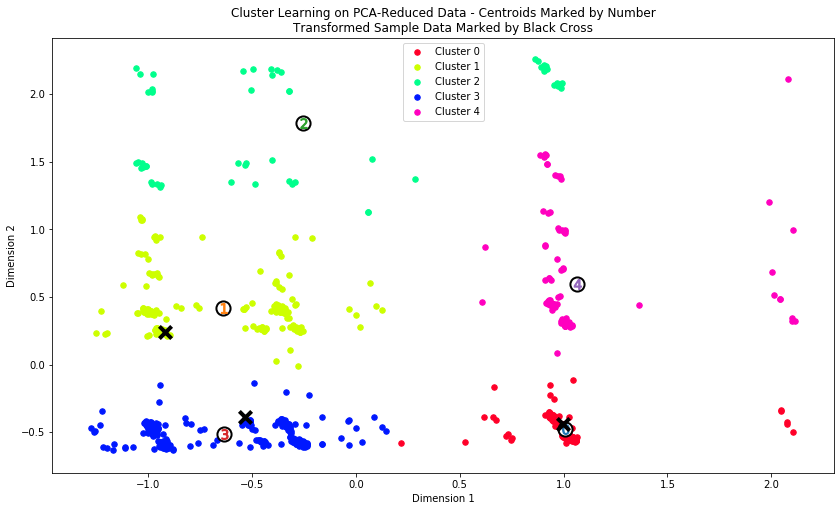

In [49]:
cluster_results(reduced_data, preds, centers, pca_samples)

In [50]:
log_centers = pca.inverse_transform(centers)

# TODO: Exponentiate the centers
true_centers = np.exp(log_centers)


# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = data.columns)
true_centers.index = segments
true_centers.loc[:, ['Gender',  'MaritalStatus', 'NuChildren', 'ResidencyDist',
       'StudentStatus', 'EducationLvl', 'LastSchoolCat',
       'HTLast3yrs', 'EmployedLast1yr', 'OccupancyStatus']]=true_centers.loc[:, ['Gender',  'MaritalStatus', 'NuChildren', 'ResidencyDist',
       'StudentStatus', 'EducationLvl', 'LastSchoolCat',
       'HTLast3yrs', 'EmployedLast1yr', 'OccupancyStatus']]-1

display(true_centers)

,Gender,MaritalStatus,NuChildren,ResidencyDist,StudentStatus,EducationLvl,LastSchoolCat,HTLast3yrs,EmployedLast1yr,OccupancyStatus,Age,Ubudehe
Segment 0,0.0,1.0,4.0,2.0,0.0,13.0,0.0,0.0,1.0,4.0,25.0,2.0
Segment 1,0.0,1.0,4.0,14.0,0.0,5.0,1.0,0.0,0.0,3.0,26.0,2.0
Segment 2,0.0,1.0,4.0,9.0,0.0,0.0,1.0,0.0,0.0,4.0,27.0,2.0
Segment 3,0.0,1.0,4.0,14.0,0.0,13.0,1.0,0.0,1.0,3.0,25.0,2.0
Segment 4,0.0,1.0,4.0,2.0,0.0,4.0,1.0,0.0,1.0,4.0,26.0,2.0


In [51]:
# Clusters' deviation from median
display(true_centers+1 - data.median())

# Clusters' deviation from mean
display(true_centers+1 - data.mean())

,Gender,MaritalStatus,NuChildren,ResidencyDist,StudentStatus,EducationLvl,LastSchoolCat,HTLast3yrs,EmployedLast1yr,OccupancyStatus,Age,Ubudehe
Segment 0,-1.0,0.0,0.0,-8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Segment 1,-1.0,0.0,0.0,4.0,0.0,-8.0,1.0,0.0,-1.0,-1.0,1.0,0.0
Segment 2,-1.0,0.0,0.0,-1.0,0.0,-13.0,1.0,0.0,-1.0,0.0,2.0,0.0
Segment 3,-1.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,0.0,-1.0,0.0,0.0
Segment 4,-1.0,0.0,0.0,-8.0,0.0,-9.0,1.0,0.0,0.0,0.0,1.0,0.0


,Gender,MaritalStatus,NuChildren,ResidencyDist,StudentStatus,EducationLvl,LastSchoolCat,HTLast3yrs,EmployedLast1yr,OccupancyStatus,Age,Ubudehe
Segment 0,-0.525405,0.056216,0.301622,-8.020541,-0.309189,4.050811,-0.902703,-0.422703,0.396757,0.267027,-0.341622,0.484324
Segment 1,-0.525405,0.056216,0.301622,3.979459,-0.309189,-3.949189,0.097297,-0.422703,-0.603243,-0.732973,0.658378,0.484324
Segment 2,-0.525405,0.056216,0.301622,-1.020541,-0.309189,-8.949189,0.097297,-0.422703,-0.603243,0.267027,1.658378,0.484324
Segment 3,-0.525405,0.056216,0.301622,3.979459,-0.309189,4.050811,0.097297,-0.422703,0.396757,-0.732973,-0.341622,0.484324
Segment 4,-0.525405,0.056216,0.301622,-8.020541,-0.309189,-4.949189,0.097297,-0.422703,0.396757,0.267027,0.658378,0.484324


In [52]:
for i, pred in enumerate(sample_preds):
    print("Sample point", i, "predicted to be in Cluster", pred)

Sample point 0 predicted to be in Cluster 3
Sample point 1 predicted to be in Cluster 0
Sample point 2 predicted to be in Cluster 1


In [53]:
to_inverse=true_centers.loc[:, ['Gender',  'MaritalStatus', 'NuChildren', 'ResidencyDist',
       'StudentStatus', 'EducationLvl', 'LastSchoolCat',
       'HTLast3yrs', 'EmployedLast1yr', 'OccupancyStatus']]

to_inverse=to_inverse.astype(int).apply(lambda x:encoder[x.name].inverse_transform(x))
to_inverse["Age"]=true_centers["Age"]
to_inverse["Ubudehe"]=true_centers["Ubudehe"]
to_inverse.to_csv("five_clusters_centroids.csv")
to_inverse

,Gender,MaritalStatus,NuChildren,ResidencyDist,StudentStatus,EducationLvl,LastSchoolCat,HTLast3yrs,EmployedLast1yr,OccupancyStatus,Age,Ubudehe
Segment 0,Female,Single,None,Gasabo,No,Senior 6,Private school,No,Yes,Temporary camp or settlement,25.0,2.0
Segment 1,Female,Single,None,Ngororero,No,Bachelor degree,Public aided school,No,No,Owner occupier,26.0,2.0
Segment 2,Female,Single,None,Kayonza,No,Advanced Diploma (A1),Public aided school,No,No,Temporary camp or settlement,27.0,2.0
Segment 3,Female,Single,None,Ngororero,No,Senior 6,Public aided school,No,Yes,Owner occupier,25.0,2.0
Segment 4,Female,Single,None,Gasabo,No,Bachelor Year 3,Public aided school,No,Yes,Temporary camp or settlement,26.0,2.0


In [136]:
# for 3, 2 was 0, 1 0
for i, pred in enumerate(sample_preds):
    print("Sample point", i, "predicted to be in Cluster", pred)

Sample point 0 predicted to be in Cluster 1
Sample point 1 predicted to be in Cluster 2
Sample point 2 predicted to be in Cluster 1


In [137]:
to_inverse=true_centers.loc[:, ['Gender',  'MaritalStatus', 'NuChildren', 'ResidencyDist',
       'StudentStatus', 'EducationLvl', 'LastSchoolCat',
       'HTLast3yrs', 'EmployedLast1yr', 'OccupancyStatus']]

to_inverse=to_inverse.astype(int).apply(lambda x:encoder[x.name].inverse_transform(x))
to_inverse["Age"]=true_centers["Age"]
to_inverse["Ubudehe"]=true_centers["Ubudehe"]
to_inverse.to_csv("three_clusters_centroids.csv")
to_inverse

,Gender,MaritalStatus,NuChildren,ResidencyDist,StudentStatus,EducationLvl,LastSchoolCat,HTLast3yrs,EmployedLast1yr,OccupancyStatus,Age,Ubudehe
Segment 0,Female,Single,None,Gatsibo,No,Certificate,Public aided school,No,No,Owner occupier,7.0,3.0
Segment 1,Female,Single,None,Ngororero,No,Certificate,Public aided school,No,Yes,Owner occupier,26.0,2.0
Segment 2,Female,Single,None,Gasabo,No,Masters degree,Public aided school,No,Yes,Temporary camp or settlement,25.0,2.0
